Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Durniat"

---

# Noise Contrastive Estimation
W poniższym zeszycie zapoznamy się w praktyce z metodą Noise Contrastive Estimation (NCE) [(Gutmann and  Hyvarinen, 2012)](https://www.jmlr.org/papers/volume13/gutmann12a/gutmann12a.pdf), w której problem nienadzorowanej estymacji rozkładu prawdopodobieństwa zamienia się na problem klasyfikacji -odróżniania rzeczywistego rozkładu od szumu. W praktyce wykorzystuje się nieco bardziej zaawansowane podejścia, jednak metoda ta stanowi podstawę uczenia kontrastowego. W ramach poniższych zadań stosować będziemy oznaczenia i terminologię z oryginalnej publikacji.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
from torch import distributions as D
import matplotlib.animation as animation
from lightning_fabric import seed_everything

/home/piotr/projects/ai/ur-l/l03-sr-17-piotrdurniat/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generowanie zbioru danych
NCE zostanie przetestowane w ramach sztucznego, prostego problemu, mianowicie estymacji rozkładu mikstur Gaussowskich. Warto pamiętać , że w NCE:
* nie znamy rzeczywistego rozkładu danych (tutaj używamy rozkładu wyłącznie do generowania danych, model nie ma informacji na jego temat),
* znamy rozkład szumu.

Poniżej znajdują się funkcje implementujące generowanie przykładów rzeczywistych oraz definicja rozkładu stanowiącego szum i generowanie z niego przykładów. 

In [6]:
def sample_noise(n: int) -> Tensor:
    gmm = get_noise_distribution()
    samples = gmm.sample((n,))
    return samples


def get_noise_distribution() -> D.Distribution:
    mix = D.Categorical(
        torch.ones(
            2,
        )
    )
    comp = D.Independent(
        D.Normal(
            torch.tensor([[-2, 0], [-10, 8]], dtype=torch.float),
            torch.ones(2, 2) * 1.25,
        ),
        1,
    )
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

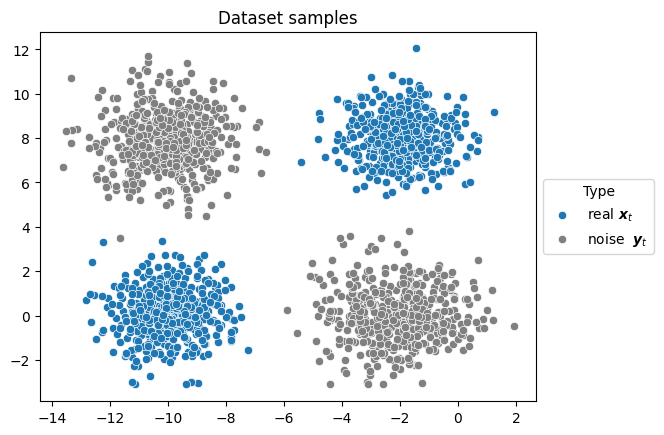

In [7]:
x, _ = datasets.make_blobs(
    n_samples=1_000,
    n_features=2,
    centers=[[-2, 8], [-10, 0]],
    cluster_std=1.05,
    random_state=42,
)
noise_samples = sample_noise(1_000)
ax = sns.scatterplot(x=x[:, 0], y=x[:, 1], label="real $\\boldsymbol{x}_t$")
sns.scatterplot(
    x=noise_samples[:, 0],
    y=noise_samples[:, 1],
    ax=ax,
    color="gray",
    label="noise  $\\boldsymbol{y}_t$",
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Type")
ax.set(title="Dataset samples", xlabel="", ylabel="")
plt.show()

## Zadanie 1.1 Implementacja NCE (1.5 pkt)
Poniżej znajduje się klasa implementuja metodę `NCE`. Do estymacji rozkładu wykorzystamy pojedyńczą wartswę liniową, która odpowiedzialna będzie za predykcję, czy dana próbka pochodzi z rozkładu rzeczywistego czy z szumu.
Predykcja prawdopodobieństwa, że dana próbka została wygenerowana z rzeczywistego rozkładu określona jest wzorem:
$$  P(C=1 | \boldsymbol{u};\boldsymbol{\theta}) = \frac{p_m(\boldsymbol{u};\boldsymbol{\theta})}{p_m(\boldsymbol{u};\boldsymbol{\theta}) + vp_n(\boldsymbol{u})},$$
gdzie $p_m$ - estymowane przez model prawdopodobieństwo, $p_n$ - prawdopodobieństwo szumu, $v$ - stosunek przykładów negatywnych do pozytywnych, $\boldsymbol{u}$ - dane wejściowe wejściowymi (szum lub dane rzeczywiste), $\boldsymbol{\theta}$ - parametry modelu.

Przyjmijmy teraz $P(C=1 | \boldsymbol{u};\boldsymbol{\theta}) = h(\boldsymbol{u};\boldsymbol{\theta})$, a następnie zdefiniujmy stosunek log-prawdopodobieństw jako: 
$$G(\boldsymbol{u};\boldsymbol{\theta}) = \ln{p_m(\boldsymbol{u};\boldsymbol{\theta})} - \ln{p_n(\boldsymbol{u})}$$
Dokonując odpowiednich przekształceń, otrzymamy wyjście modelu jako:
$$ h(\boldsymbol{u};\boldsymbol{\theta}) = \frac{1}{1+v\exp(-G(\boldsymbol{u};\boldsymbol{\theta}))} $$

Aby wytrenować model estymujący rozkład należy skorzystać ze standardowej dla klasyfikacji binarnej funkcji straty:
$$ l(\boldsymbol{\theta}) = \sum_{t=1}^{Td}\ln{h(\boldsymbol{x}_t; \boldsymbol{\theta}}) + \sum_{t=1}^{Tn}\ln{(1-h(\boldsymbol{y}_t; \boldsymbol{\theta}})),$$
gdzie $T_d$ - liczba przykładów pozytywnych (liczba przykładów z danych rzeczywistych), $T_n$ - liczba przykładów negatywnych (liczba przykładów danych losowanych z szumu), $\boldsymbol{x}_t$ - przykład pozytywny, $\boldsymbol{y}_t$ - przykład negatywny (szum).

Zaimplementuj poniższe funkcje:
1. `log_prob_diff` (0.5 pkt) - oblicza stosunek log-prawdopodobieństw, tj. funkcje $G(\boldsymbol{u};\boldsymbol{\theta})$
2. `loss` (0.5 pkt) - oblicza wartość funkcji straty $l(\boldsymbol{\theta})$
3. `predict_proba` (0.5 pkt) - oblicza wartość prawdopodobieństwa przynależności do rozkładu danych rzeczywistych, czyli $P(C=1 | \boldsymbol{u};\boldsymbol{\theta})$ lub $ h(\boldsymbol{u};\boldsymbol{\theta})$

In [12]:
EPSILON = 1e-8


class SimpleNCE(nn.Module):
    """Implementation of NCE method.
    Reference: http://proceedings.mlr.press/v9/gutmann10a/gutmann10a.pdf
    """

    def __init__(self, in_dim: int, neg_pos_ratio: float):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

        self.in_dim = in_dim
        self.v = neg_pos_ratio

        self.noise_dist = get_noise_distribution()

    def forward(self, x: Tensor) -> Tensor:
        # prepare noise samples
        num_noise_samples = int(x.size(0) * self.v)
        noise_samples = self.noise_dist.sample((num_noise_samples,))

        g_data = self.log_prob_diff(x)
        g_noise = self.log_prob_diff(noise_samples)

        h_data = self.sigm(g_data) + EPSILON
        h_noise = self.sigm(g_noise)

        return self.loss(h_data, h_noise)

    def log_prob_diff(self, u: Tensor) -> Tensor:
        """Computes log_prob_diff of data being real (estimated by model) or noise (analytically from distribution)."""
        # TU WPISZ KOD
        # TODO: should this be inside log?
        return self.linear(u).squeeze(-1) - self.noise_dist.log_prob(u)

    def loss(self, h_data: Tensor, h_noise: Tensor) -> Tensor:
        """Computes NCE loss, i.e., binary cross entropy"""
        # TU WPISZ KOD

        # print(h_data.shape)

        return -(
            torch.sum(torch.log(h_data), dim=0)
            + torch.sum(torch.log(1 - h_noise), dim=0)
        )

    def predict_proba(self, x: Tensor) -> Tensor:
        """Predicts probability of data being from real distribution."""
        # TU WPISZ KOD
        return self.sigm(self.log_prob_diff(x))

    def sigm(self, u: Tensor) -> Tensor:
        """Modified sigmoid (accounts for neg_pos_ratio)."""
        return 1 / (1 + self.v * torch.exp(-u))

In [10]:
@torch.no_grad()
def eval_on_grid(
    model: nn.Module,
    x_range: tuple[int, int],
    y_range: tuple[int, int],
    resolution: int = 100,
) -> tuple[Tensor, Tensor, Tensor]:
    """Generates grid of points which are then evaluated against estimated model."""
    grid_x1, grid_x2 = torch.meshgrid(
        torch.linspace(x_range[0], x_range[1], resolution),
        torch.linspace(y_range[0], y_range[1], resolution),
        indexing="ij",
    )
    grid = torch.stack([grid_x1.flatten(), grid_x2.flatten()], dim=1)
    proba = model.predict_proba(grid).reshape(resolution, resolution)
    return grid_x1, grid_x2, proba

### Estymacja (uczenie)
1. Dokładnie zapoznaj się z procedurą uczenia
2. Uruchom uczenie i zaobserwuj jego przebieg na wykresie wartości funkcji straty.
3. **Uuchom trening kilka razy, zmieniając wartość parametru `POS_NEG_RATIO`, co zaobserwowałeś? (bądź gotowy odpowiedzieć na to pytanie na zajęciach)**

Seed set to 42
100%|██████████| 15/15 [00:07<00:00,  1.90it/s, loss=11.6]


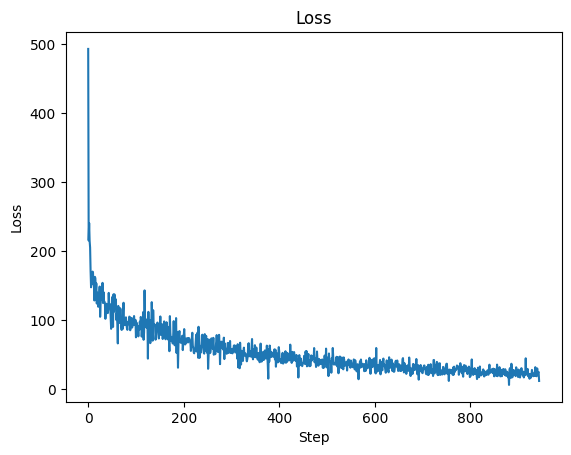

In [13]:
EPOCHS = 15
LR = 1e-4
BATCH_SIZE = 16
POS_NEG_RATIO = 100

xs = torch.tensor(x, dtype=torch.float)
loader = DataLoader(TensorDataset(xs), batch_size=BATCH_SIZE, shuffle=True)

seed_everything(42)
model = SimpleNCE(in_dim=2, neg_pos_ratio=POS_NEG_RATIO)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

losses = []

x_range = (x[:, 0].min(), x[:, 0].max())
y_range = (x[:, 1].min(), x[:, 1].max())
eval_snapshots = []

model.eval()
eval_res = eval_on_grid(
    model,
    x_range=x_range,
    y_range=y_range,
)
eval_snapshots.append(eval_res)

with trange(EPOCHS) as pbar:
    for epoch in pbar:
        model.train()
        for x_batch, *_ in loader:
            optimizer.zero_grad()
            loss = model(x_batch)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            pbar.set_postfix({"loss": loss.item()})

        if epoch % 5 == 0:
            model.eval()
            eval_res = eval_on_grid(
                model,
                x_range=x_range,
                y_range=y_range,
            )
            eval_snapshots.append(eval_res)

ax = sns.lineplot(x=range(len(losses)), y=losses)
ax.set(title="Loss", xlabel="Step", ylabel="Loss")
plt.show()

### Wizualizacja estymowanego rozkładu
Wykonaj poniższą komórkę i sprawdź, jakie prawdopodobieństwa model przypisał w poszczególnych obszarach. Co to oznacza, zinterpretuj wynik.

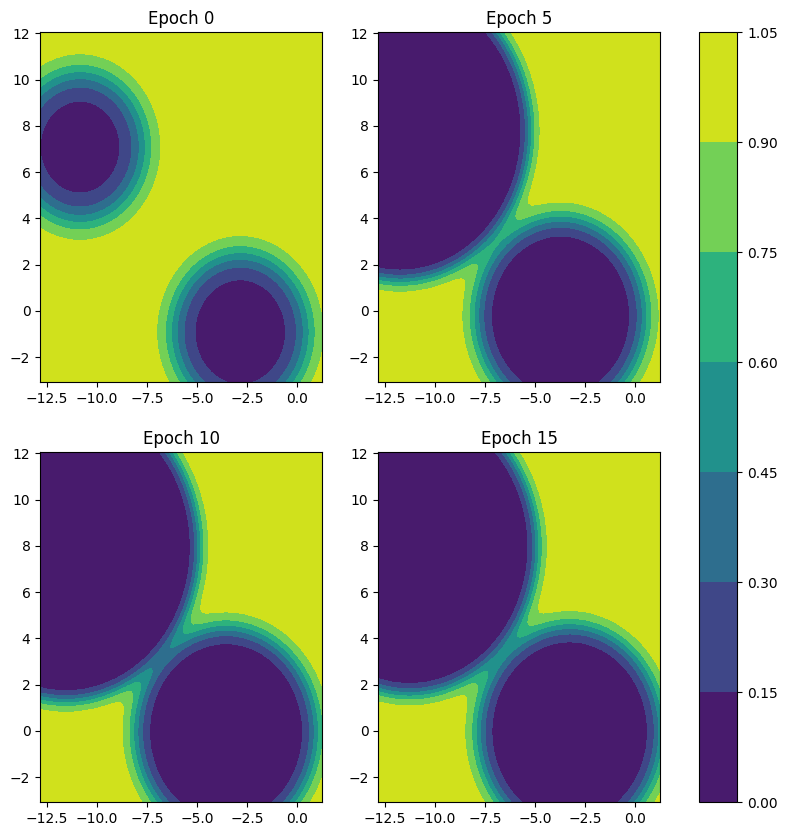

In [14]:
import math


num_steps = len(eval_snapshots)
col_wrap = 2
num_rows = math.ceil(num_steps / col_wrap)
fig, axes = plt.subplots(
    num_rows, col_wrap, figsize=(5 * col_wrap, 5 * num_rows), squeeze=False
)
axes = axes.flatten()

for i in range(num_steps):
    grid_x, grid_y, proba = eval_snapshots[i]
    grid_x, grid_y, proba = grid_x.numpy(), grid_y.numpy(), proba.numpy()
    cont = axes[i].contourf(grid_x, grid_y, proba)
    axes[i].set(title=f"Epoch {i*5}")

fig.colorbar(cont, ax=axes.ravel().tolist())
plt.show()